In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS

import pandas_ta as ta
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [10]:
input_folder_db = '../../data/Model1'

data_path = 'MNQ/Bar_Entry_Positions_2021-09-01_2021-10-14.parquet'

data = pd.read_parquet(os.path.join(input_folder_db, data_path))

In [11]:
data.drop(columns = ['OI'], inplace= True)

In [13]:
data.head()

,Date,Time,Open,High,Low,Close,Vol,year,month,day,hour,minute,ticker,datetime,Time_tuple,entry_market,target,stop,entry_type,risk_type
index,,,,,,,,,,,,,,,,,,,,
0,2021-09-01,15:10,15616.75,15617.50,15615.75,15616.50,92.0,2021,9,1,15,10,MNQ,2021-09-01 15:10:00,"(15, 10)",15616.625,15636.625,15606.625,0.0,1.0
1,2021-09-01,15:11,15616.00,15620.00,15615.50,15620.00,255.0,2021,9,1,15,11,MNQ,2021-09-01 15:11:00,"(15, 11)",15617.750,15637.750,15607.750,0.0,1.0
2,2021-09-01,15:12,15619.50,15620.00,15617.00,15619.75,150.0,2021,9,1,15,12,MNQ,2021-09-01 15:12:00,"(15, 12)",15618.500,15638.500,15608.500,0.0,1.0
3,2021-09-01,15:13,15620.00,15621.25,15618.75,15619.25,186.0,2021,9,1,15,13,MNQ,2021-09-01 15:13:00,"(15, 13)",15620.000,15640.000,15610.000,0.0,1.0
4,2021-09-01,15:14,15619.25,15619.50,15617.25,15618.25,104.0,2021,9,1,15,14,MNQ,2021-09-01 15:14:00,"(15, 14)",15618.375,15638.375,15608.375,0.0,1.0


## Compute Relative Strength Index (RSI)

In [9]:
data['rsi'] = data.groupby('ticker').Close.apply(RSI)

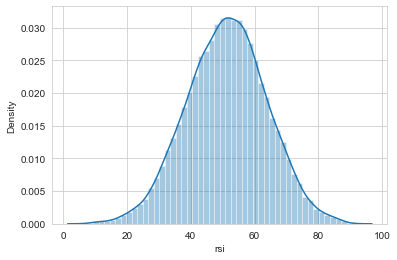

In [10]:
sns.distplot(data.rsi)

## Calculate Bollinger Bands

In [11]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [12]:
data = (data.join(data
                      .groupby('ticker')
                      .Close
                      .apply(compute_bb)))

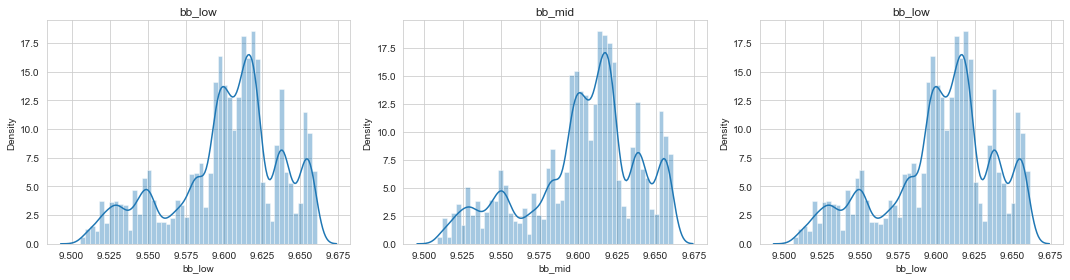

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [14]:
data['bb_up'] = data.bb_high.sub(np.log1p(data.Close))
data['bb_down'] = np.log1p(data.Close).sub(data.bb_low)

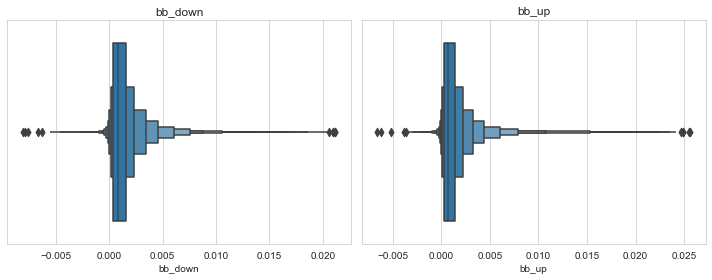

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

## Compute Average True Range

In [16]:
data.head()

,Date,Time,Open,High,Low,Close,Vol,year,month,day,...,entry_market,target,stop,entry_type,rsi,bb_high,bb_mid,bb_low,bb_up,bb_down
index,,,,,,,,,,,,,,,,,,,,,
0,2021-06-01,15:10,13719.50,13720.75,13718.50,13720.25,102.0,2021,6,1,...,13719.625,13744.625,13709.625,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-01,15:11,13720.50,13721.75,13719.75,13721.50,157.0,2021,6,1,...,13720.750,13745.750,13710.750,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-01,15:12,13721.50,13723.50,13721.25,13722.75,163.0,2021,6,1,...,13722.375,13747.375,13712.375,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-01,15:13,13723.00,13725.50,13722.75,13724.00,327.0,2021,6,1,...,13724.125,13749.125,13714.125,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-01,15:14,13723.75,13726.25,13723.50,13725.50,289.0,2021,6,1,...,13724.875,13749.875,13714.875,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
atr = ta.atr(data.High, 
        data.Low, 
        data.Close)


data.loc[:,'natr'] = atr.sub(atr.mean()).div(atr.std())


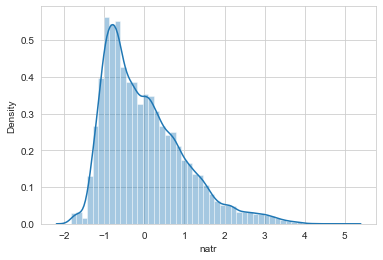

In [18]:
sns.distplot(data.natr);

## Compute Moving Average Convergence/Divergence

In [19]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

data['macd'] = data.groupby('ticker').Close.apply(compute_macd)

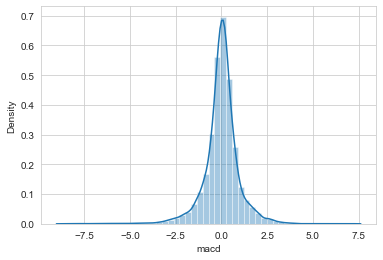

In [20]:
sns.distplot(data.macd);

## Compute dollar volume to determine universe

In [21]:
data['dollar_volume'] = (data.loc[:, 'Close']
                           .mul(data.loc[:, 'Vol'], axis=0))

data.dollar_volume /= 1e6

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38958 entries, 0 to 38957
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           38958 non-null  datetime64[ns]
 1   Time           38958 non-null  object        
 2   Open           38958 non-null  float64       
 3   High           38958 non-null  float64       
 4   Low            38958 non-null  float64       
 5   Close          38958 non-null  float64       
 6   Vol            38958 non-null  float64       
 7   year           38958 non-null  int64         
 8   month          38958 non-null  int64         
 9   day            38958 non-null  int64         
 10  hour           38958 non-null  object        
 11  minute         38958 non-null  object        
 12  ticker         38958 non-null  object        
 13  datetime       38958 non-null  datetime64[ns]
 14  Time_tuple     38958 non-null  object        
 15  entry_market   3895

##  Create Minute Return Series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [23]:
data.set_index(['ticker','datetime'], inplace = True)

In [24]:
data.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'year', 'month',
       'day', 'hour', 'minute', 'Time_tuple', 'entry_market', 'target', 'stop',
       'entry_type', 'rsi', 'bb_high', 'bb_mid', 'bb_low', 'bb_up', 'bb_down',
       'natr', 'macd', 'dollar_volume'],
      dtype='object')

In [25]:
outlier_cutoff = 0.01
lags = [1, 3, 5, 15]
returns = []

In [26]:
for lag in lags:
    returns.append(data
                   .Close
                   .unstack('ticker') # Get a Matrix of the Ticker Close values, colums are the tickers
                   .sort_index() # Sort by Date
                   .pct_change(lag) # Calculate percentage change of the respective lag value
                   .stack('ticker') # Stack back to original index order
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff))) # Cutoff outliers
                   .add(1) # add 1 to the returns
                   .pow(1/lag) # apply n root for n = lag
                   .sub(1) #substract 1
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38957 entries, ('MNQ', Timestamp('2021-06-01 15:11:00')) to ('MNQ', Timestamp('2021-10-14 21:50:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   38957 non-null  float64
 1   return_3m   38955 non-null  float64
 2   return_5m   38953 non-null  float64
 3   return_15m  38943 non-null  float64
dtypes: float64(4)
memory usage: 2.7+ MB


In [27]:
returns.describe()

,return_1m,return_3m,return_5m,return_15m
count,38957.000000,38955.000000,38953.000000,38943.000000
mean,0.000002,0.000003,0.000003,0.000003
std,0.000331,0.000198,0.000157,0.000097
min,-0.001042,-0.000638,-0.000517,-0.000323
25%,-0.000160,-0.000090,-0.000070,-0.000042
50%,0.000000,0.000005,0.000003,0.000005
75%,0.000165,0.000098,0.000077,0.000049
max,0.001085,0.000646,0.000513,0.000317


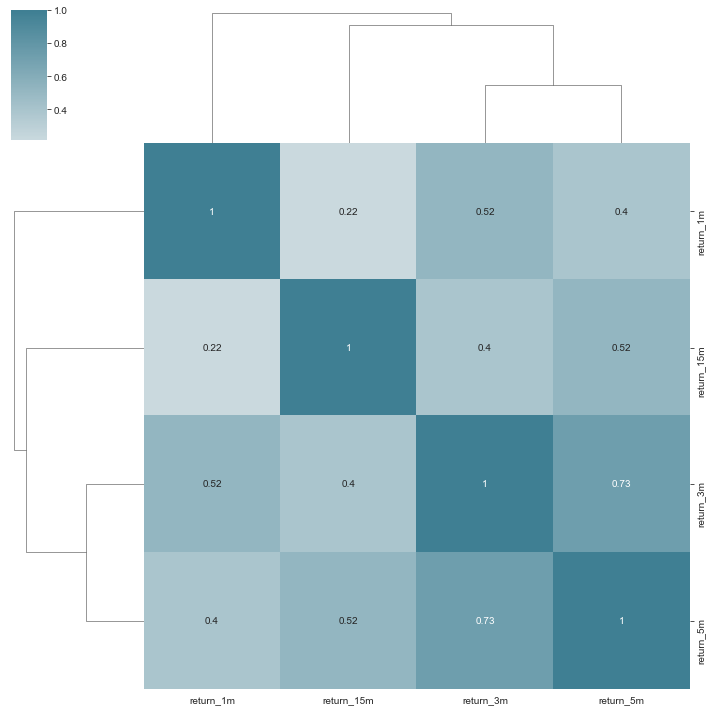

In [28]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [29]:
    returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38957 entries, ('MNQ', Timestamp('2021-06-01 15:11:00')) to ('MNQ', Timestamp('2021-10-14 21:50:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   38957 non-null  float64
 1   return_3m   38955 non-null  float64
 2   return_5m   38953 non-null  float64
 3   return_15m  38943 non-null  float64
dtypes: float64(4)
memory usage: 2.7+ MB


In [30]:
data = data.join(returns).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37484 entries, ('MNQ', Timestamp('2021-06-01 15:43:00')) to ('MNQ', Timestamp('2021-10-14 21:34:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37484 non-null  datetime64[ns]
 1   Time           37484 non-null  object        
 2   Open           37484 non-null  float64       
 3   High           37484 non-null  float64       
 4   Low            37484 non-null  float64       
 5   Close          37484 non-null  float64       
 6   Vol            37484 non-null  float64       
 7   year           37484 non-null  int64         
 8   month          37484 non-null  int64         
 9   day            37484 non-null  int64         
 10  hour           37484 non-null  object        
 11  minute         37484 non-null  object        
 12  Time_tuple     37484 non-null  object        
 13  entry_market   37484 non-null  float64       

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows

In [31]:
for lag in [3, 5, 15]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37484 entries, ('MNQ', Timestamp('2021-06-01 15:43:00')) to ('MNQ', Timestamp('2021-10-14 21:34:00'))
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37484 non-null  datetime64[ns]
 1   Time           37484 non-null  object        
 2   Open           37484 non-null  float64       
 3   High           37484 non-null  float64       
 4   Low            37484 non-null  float64       
 5   Close          37484 non-null  float64       
 6   Vol            37484 non-null  float64       
 7   year           37484 non-null  int64         
 8   month          37484 non-null  int64         
 9   day            37484 non-null  int64         
 10  hour           37484 non-null  object        
 11  minute         37484 non-null  object        
 12  Time_tuple     37484 non-null  object        
 13  entry_market   37484 non-null  float64       

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [33]:
data.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'year', 'month',
       'day', 'hour', 'minute', 'Time_tuple', 'entry_market', 'target', 'stop',
       'entry_type', 'rsi', 'bb_high', 'bb_mid', 'bb_low', 'bb_up', 'bb_down',
       'natr', 'macd', 'dollar_volume', 'return_1m', 'return_3m', 'return_5m',
       'return_15m', 'momentum_3', 'momentum_5', 'momentum_3_5', 'momentum_15',
       'momentum_3_15'],
      dtype='object')

In [34]:
forecast_horizon = 2
data[f'target_fh_{forecast_horizon}'] = data.groupby('ticker')[f'entry_type'].shift(-forecast_horizon)

In [35]:
data.head()

Date   Time      Open      High       Low  \
ticker datetime                                                              
MNQ    2021-06-01 15:43:00 2021-06-01  15:43  13745.25  13748.00  13739.00   
       2021-06-01 15:44:00 2021-06-01  15:44  13740.25  13742.75  13734.50   
       2021-06-01 15:45:00 2021-06-01  15:45  13738.00  13739.75  13733.00   
       2021-06-01 15:46:00 2021-06-01  15:46  13734.00  13741.75  13733.50   
       2021-06-01 15:47:00 2021-06-01  15:47  13734.75  13738.00  13728.25   

                               Close     Vol  year  month  day  ... return_1m  \
ticker datetime                                                 ...             
MNQ    2021-06-01 15:43:00  13740.25  1009.0  2021      6    1  ... -0.000327   
       2021-06-01 15:44:00  13738.00   786.0  2021      6    1  ... -0.000164   
       2021-06-01 15:45:00  13733.75   642.0  2021      6    1  ... -0.000309   
       2021-06-01 15:46:00  13735.00  1370.0  2021      6    1  ...  0.000091   
       2021-06-01 15:47:00  13733.25  1828.0  2021      6    1  ... -0.000127   

                           return_3m return_5m  return_15m  momentum_3  \
ticker datetime                                                          
MNQ    2021-06-01 15:43:00  0.000188  0.000226    0.000052    0.000515   
       2021-06-01 15:44:00 -0.000224  0.000131    0.000035   -0.000061   
       2021-06-01 15:45:00 -0.000267  0.000018    0.000005    0.000043   
       2021-06-01 15:46:00 -0.000127 -0.000178    0.000005   -0.000218   
       2021-06-01 15:47:00 -0.000115 -0.000167    0.000008    0.000012   

                            momentum_5  momentum_3_5  momentum_15  \
ticker datetime                                                     
MNQ    2021-06-01 15:43:00    0.000553      0.000038     0.000380   
       2021-06-01 15:44:00    0.000295      0.000355     0.000199   
       2021-06-01 15:45:00    0.000328      0.000285     0.000314   
       2021-06-01 15:46:00   -0.000269     -0.000051    -0.000086   
       2021-06-01 15:47:00   -0.000040     -0.000052     0.000136   

                            momentum_3_15  target_fh_2  
ticker datetime                                         
MNQ    2021-06-01 15:43:00      -0.000136          0.0  
       2021-06-01 15:44:00       0.000260          0.0  
       2021-06-01 15:45:00       0.000272          0.0  
       2021-06-01 15:46:00       0.000132          0.0  
       2021-06-01 15:47:00       0.000124          0.0  

[5 rows x 36 columns]

In [36]:
data = data.dropna()

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37482 entries, ('MNQ', Timestamp('2021-06-01 15:43:00')) to ('MNQ', Timestamp('2021-10-14 21:32:00'))
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37482 non-null  datetime64[ns]
 1   Time           37482 non-null  object        
 2   Open           37482 non-null  float64       
 3   High           37482 non-null  float64       
 4   Low            37482 non-null  float64       
 5   Close          37482 non-null  float64       
 6   Vol            37482 non-null  float64       
 7   year           37482 non-null  int64         
 8   month          37482 non-null  int64         
 9   day            37482 non-null  int64         
 10  hour           37482 non-null  object        
 11  minute         37482 non-null  object        
 12  Time_tuple     37482 non-null  object        
 13  entry_market   37482 non-null  float64       

Data Time Fourier Transformation

In [38]:
# TODO: add Fourier Transformation to datetime
data.loc[:,'hour'] = data['hour'].astype('int64')
data.loc[:,'minute'] = data['minute'].astype('int64')

## Data Storage

In [39]:
data.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'year', 'month',
       'day', 'hour', 'minute', 'Time_tuple', 'entry_market', 'target', 'stop',
       'entry_type', 'rsi', 'bb_high', 'bb_mid', 'bb_low', 'bb_up', 'bb_down',
       'natr', 'macd', 'dollar_volume', 'return_1m', 'return_3m', 'return_5m',
       'return_15m', 'momentum_3', 'momentum_5', 'momentum_3_5', 'momentum_15',
       'momentum_3_15', 'target_fh_2'],
      dtype='object')

In [40]:
output_folder_db ='../../data/Model2'

In [41]:
output_location = os.path.join(output_folder_db, 'Feature_Engineering',  'NQ', 
                            ('Model2_Feature_Engineering_{}_{}.parquet'
                            .format( data['Date'].min().strftime('%Y-%m-%d'),
                                    data['Date'].max().strftime('%Y-%m-%d'))))

data.to_parquet(output_location , engine = 'fastparquet', compression = 'gzip')

In [42]:
output_location

'../../data/Model2\\Feature_Engineering\\NQ\\Model2_Feature_Engineering_2021-06-01_2021-10-14.parquet'